In [1]:
import torch
import numpy as np
from tqdm import tqdm
from scipy.stats.distributions import chi2
from scipy.stats import pearsonr
import pickle

import matplotlib.pyplot as plt
from scipy.stats import linregress
import seaborn as sns
import random
import matplotlib.animation as animation
import sys, os

path = os.path.dirname(os.getcwd())
sys.path.append(path)

from utils.plots import *
from utils.funcs import *
from utils.visualize_network import *
from utils.visualize_hidden_network import *

from boltzmann_machines.RTRBM import RTRBM
from boltzmann_machines.RBM import RBM

from data.load_data import *
from data.mock_data import *
from data.reshape_data import *

# spikes, behavior, coordinates, df, stimulus = loaddata()

"""
to dump:

path = os.path.dirname(os.getcwd())
pickle.dump(rtrbm, open(path + '\\results\\RTRBMs\\RTRBMs1', 'wb'))

to load:

check1 = pickle.load(open(path + '\\results\\RTRBMs\\RTRBMs1', 'rb'))
"""
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [2]:
dataset = pickle.load(open(r'D:\RU\OneDrive\Intern\rtrbm_master\data\Surrogate data\Hidden_trace_' + str(10), 'rb'))
[N, C_E, C_I, EI, IE, resolution, T, dt, T_step, spikes_true, spikes_train, spike_thres, I_inj, V, h, I_ext] = dataset

In [3]:
spike_thres = np.flip(np.sort(spikes_train.ravel()))[int(np.ceil(0.15*(spikes_train.shape[0]*spikes_train.shape[1])))]
h = 1.0 * (spikes_train > spike_thres)


#### Hidden trace dynamics 

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 81.19it/s]


Text(0, 0.5, 'negative correlation')

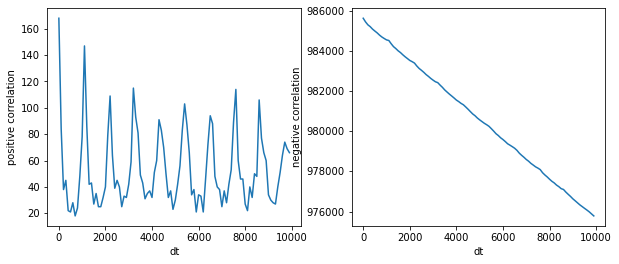

In [4]:
sum_spikes = np.sum(np.array(spikes_true), 0)
T = 10000
DT = 100
N_H = 10
pos_time_corr = np.zeros((T // DT))
neg_time_corr = np.zeros((T // DT))
for t in tqdm(range(1, T+1, DT)):
    pos_time_corr[(t-1) // DT] = np.correlate(sum_spikes[t:], sum_spikes[:-t])
    neg_time_corr[(t-1) // DT] = np.correlate(sum_spikes[t:]-1, sum_spikes[:-t]-1)


dt = np.arange(0, T, DT)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(dt, pos_time_corr)
axes[1].plot(dt, neg_time_corr)
axes[0].set_xlabel('dt')
axes[1].set_xlabel('dt')
axes[0].set_ylabel('positive correlation')
axes[1].set_ylabel('negative correlation')

Text(0, 0.5, 'negative correlation')

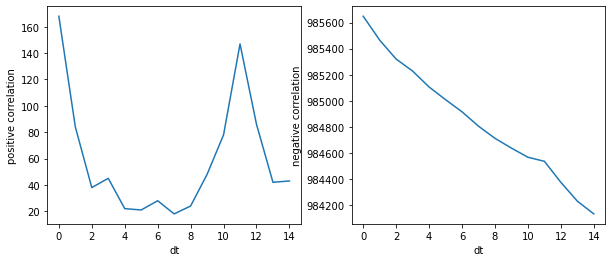

In [5]:
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(pos_time_corr[:15])
axes[1].plot(neg_time_corr[:15])
axes[0].set_xlabel('dt')
axes[1].set_xlabel('dt')
axes[0].set_ylabel('positive correlation')
axes[1].set_ylabel('negative correlation')

correlations indeed spike after 1000 timesteps, so resolution is correct.

Now take the sampled data

<AxesSubplot:>

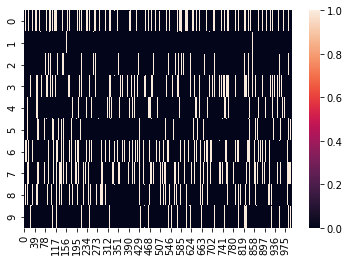

In [6]:
data = torch.tensor(spikes_train > spike_thres, dtype=torch.float)
sns.heatmap(data)

System dies out, only take forst 6000 timesteps

Check time correlation

100%|██████████████████████████████████████████████████████████████████████████████| 1499/1499 [24:02<00:00,  1.04it/s]


Text(0, 0.5, 'sum negative correlation')

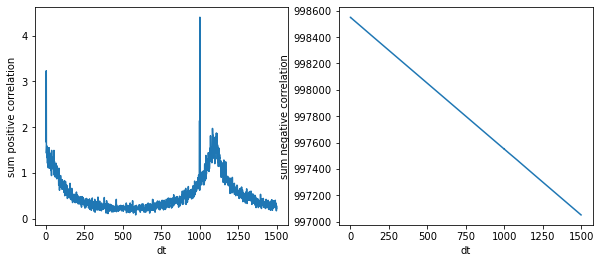

In [7]:
data_numpy = np.array(spikes_true)
T = 1500
N_H = 10
pos_time_corr = np.zeros((N_H, N_H, T-1))
neg_time_corr = np.zeros((N_H, N_H, T-1))
for t in tqdm(range(1, T)):
    for h in range(N_H):
        for hh in range(N_H):
            pos_time_corr[h, hh, t-1] = np.correlate(data_numpy[h, t:], data_numpy[hh, :-t])
            neg_time_corr[h, hh, t-1] = np.correlate(data_numpy[h, t:]-1, data_numpy[hh, :-t]-1)


dt = np.arange(1, T, 1)
fig, axes = plt.subplots(1, 2, figsize=(10,4))
axes[0].plot(dt, np.mean(pos_time_corr, (0, 1)))
axes[1].plot(dt, np.mean(neg_time_corr, (0, 1)))
axes[0].set_xlabel('dt')
axes[1].set_xlabel('dt')
axes[0].set_ylabel('sum positive correlation')
axes[1].set_ylabel('sum negative correlation')

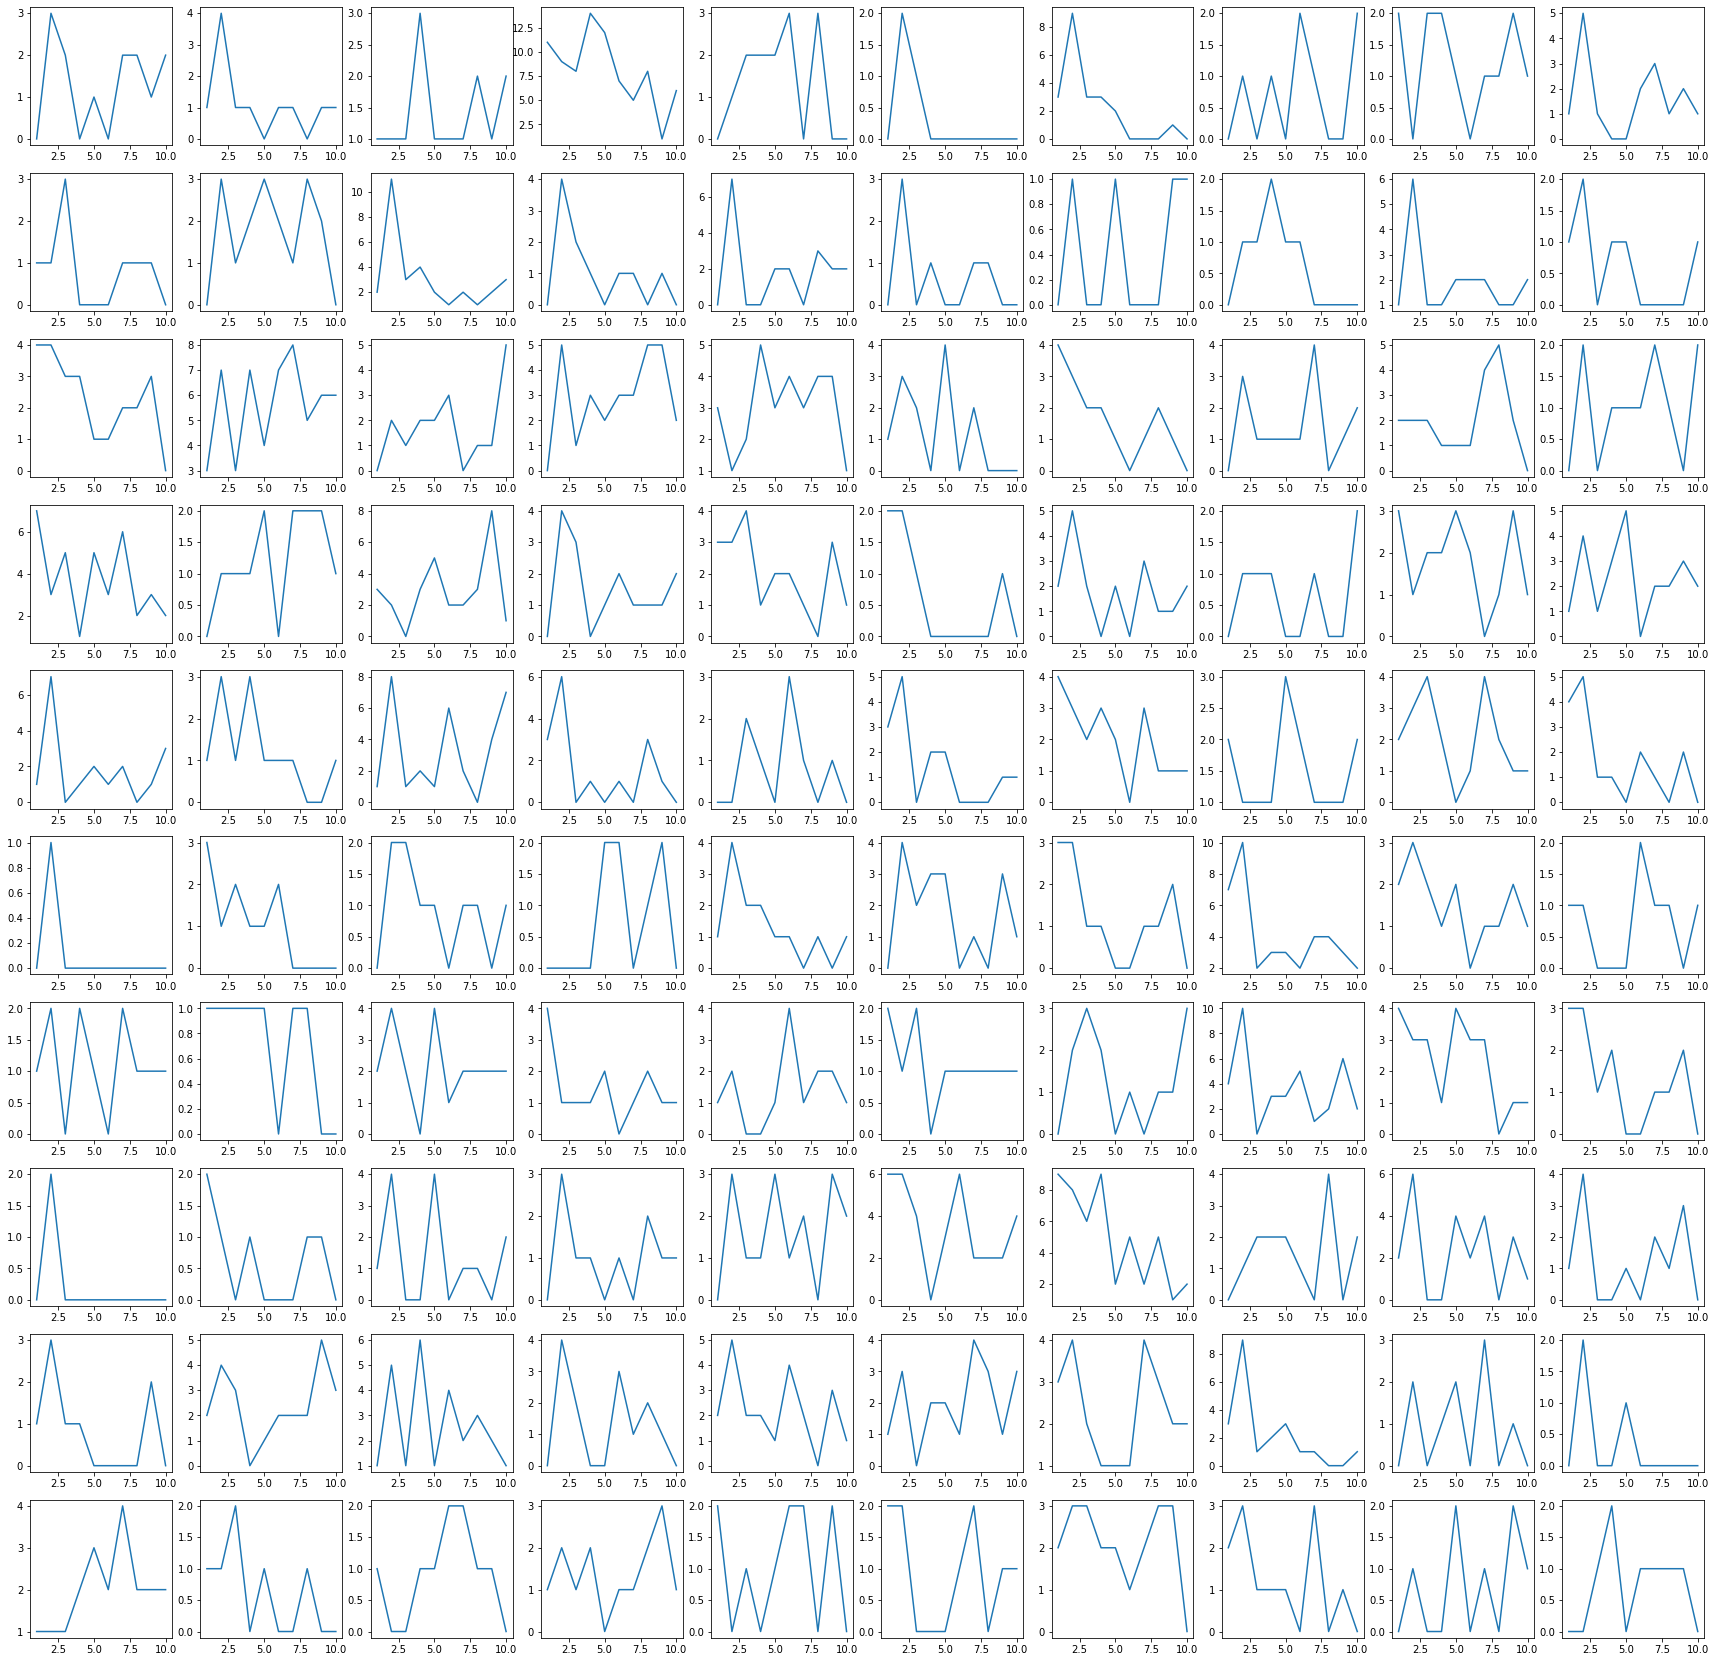

In [8]:
fig, axes = plt.subplots(10, 10, figsize=(30,30))
T=10
for i, axs in enumerate(axes):
    for j, ax in enumerate(axs):
        ax.plot(dt[:T], pos_time_corr[i, j, :T])
        #ax.set_title('correlation hidden neuron ' + str(i) + ' + ' + str(j))